## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch.nn as nn

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import SCALIB modules for NN development
import scalib.cdm as cdm            # Conjunction Data Messages
import scalib.event as event        # Conjunction Events
import scalib.nn as snn             # NN models
import scalib.cells as cell         # RNN cell architectures

# Import kessler RNN model
from scalib.kessler import LSTMPredictor

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = utils.os.path.join(utils.cwd,'data/esa-challenge/train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 2000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)

# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:10s |  193.41   | Dataset imported (2000 events).         

| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:30s |   64.70   | Imported as DataFrame.                 

Test data: ConjunctionEventsDataset(Events:100 | Number of CDMs per event: 1 (min), 22 (max), 12.80 (mean))
Training and validation data: ConjunctionEventsDataset(Events:1900 | Number of CDMs per event: 1 (min), 22 (max), 13.45 (mean))


### [Kessler](https://github.com/kesslerlib/kessler.git)'s LSTMPredictor model

In [3]:
# Create an LSTM predictor, specialized to the nn_features we extracted above
model_kessler = LSTMPredictor(lstm_size=256, lstm_depth=1, dropout=0.2, 
                      features=nn_features)

/opt/homebrew/anaconda3/envs/irpenv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [4]:
# Start training
model_kessler.learn(events_train_and_val, epochs = 3, lr = 1e-3, 
                    batch_size = 16, device = 'cpu', valid_proportion = 0.15, 
                    num_workers = 4, event_samples_for_stats = 1000)

LSTM predictor with params: 348,738
Computing normalization statistics

| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1000/1000)| 00h:00m:00s | 117480.93 | Imported as DataFrame.                 



## 3.- Recurrent Neural Network model configuration

### 3.1.- RNN layer and cell architecture definition

#### 3.1.1.- [Kessler](https://github.com/kesslerlib/kessler.git)'s configuration

In [5]:
# # Initialize LSTM architecture using custom cell
# layers = nn.ModuleDict({'lstm': nn.LSTM(input_size = input_size,
#                                         batch_first = True,
#                                         hidden_size = 256,
#                                         num_layers = 1,
#                                         dropout = 0.2)})

#### 3.1.2.- LSTM layer with *Vanilla* cell architecture

In [6]:
# # Initialize LSTM architecture using custom cell
# layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size,
#                                          batch_first = True, 
#                                          hidden_size = 256, 
#                                          num_layers = 1,
#                                          dropout = 0.2,
#                                          cell = cell.LSTM_Vanilla)})

#### 3.1.3.- LSTM layer with *SLIMX* cell architecture (*x* = 1, 2, or 3)

In [16]:
# Initialize LSTM architecture using SLIMx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
cell_args = dict(slim_version = 2)
layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size, 
                                         hidden_size = 256,
                                         cell = cell.LSTM_SLIMX, 
                                         num_layers = 1,
                                         dropout = 0.2,
                                         **cell_args)})

/Users/jjrr/Documents/SCA-Project/scalib/notebooks/../scalib/nn.py:278: UserWarning: Dropout parameter in LSTM class adds dropout layers after all but last recurrent layer. It expects num_layers greater > 1, but got num_layers = 1.
  warnings.warn(


#### 3.1.4.- LSTM layer with no *X* gate (NXG) in cell architecture (*X* = Input, Forget or Output)

In [8]:
# # Initialize LSTM architecture using NXG cell architecture (one of the 
# # information gates within the cell is cancelled out. 
# cell_args = dict(drop_gate = 'input')
# layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size, 
#                                          hidden_size = 256,
#                                          cell = cell.LSTM_NXG, 
#                                          num_layers = 2,
#                                          dropout = 0.2,
#                                          **cell_args)})

#### 3.1.5.- LSTM layer with no activation function at *X* gate (NXGAF) in cell architecture (*X* = Input, Forget, Output, or Cell)

In [9]:
# # Initialize LSTM architecture using NXG cell architecture (one of the 
# # information gates within the cell is cancelled out. 
# cell_args = dict(naf_gate = 'input')
# layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size, 
#                                          hidden_size = 256,
#                                          cell = cell.LSTM_NXGAF, 
#                                          num_layers = 2,
#                                          dropout = 0.2,
#                                          **cell_args)})

#### 3.1.6.- LSTM-Attention-LSTM layer

In [10]:
# # Initialize encoder
# encoder = snn.LSTM(input_size = input_size, 
#                     hidden_size = 256,
#                     cell = cell.LSTM_Vanilla,
#                     dropout = 0.2)

# # Initialize decoder
# decoder = snn.LSTM(input_size = encoder.hidden_size, 
#                     hidden_size = encoder.hidden_size,
#                     cell = cell.LSTM_Vanilla,
#                     dropout = 0.2)

# # Get the SelfAttention layer (SelfAttention)
# attention = snn.SelfAttentionLayer(encoder = encoder, decoder = decoder)

# layers = nn.ModuleDict({'lstm_encoder': encoder,
#                         'attention': attention,
#                         'lstm_decoder': decoder})

# # print(layers)

### 3.2.- Model instanciation

In [17]:
# Add remaining parameters for the model instanciation.
layers.update({'dropout': nn.Dropout(p = 0.2),
               'relu': nn.ReLU(),
               'linear': nn.Linear(256, output_size)})

# Print model.
print(f'\n{layers}\n')

# Initialize model.
model = snn.ConjunctionEventForecaster(layers = layers, features = nn_features)


ModuleDict(
  (lstm): LSTM(
    (layers): ModuleList(
      (0): LSTMLayer(
        (cell): LSTM_SLIMX(
          (_sigmoid): Sigmoid()
          (_tanh): Tanh()
          (gate_forget_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_input_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_cell_x): Linear(in_features=66, out_features=256, bias=True)
          (gate_cell_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_output_h): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (linear): Linear(in_features=256, out_features=66, bias=True)
)



### Model training

In [18]:
# Start training
model.learn(events_train_and_val, epochs = 3, lr = 1e-3, batch_size = 16, 
            device = 'cpu', valid_proportion = 0.15, num_workers = 4,
            event_samples_for_stats = 1000)

Number of learnable parameters of the model: 296,258

| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (1000/1000)| 00h:00m:00s | 77620.55  | Imported as DataFrame.                 

FORECASTING MODEL TRAINING:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (291/291)| 00h:02m:48s |   1.73    | Minibatch 97/97 | Loss -> Train = 3.0027e-01 : Valid = 2.3211e-01


##### Training vs validation loss

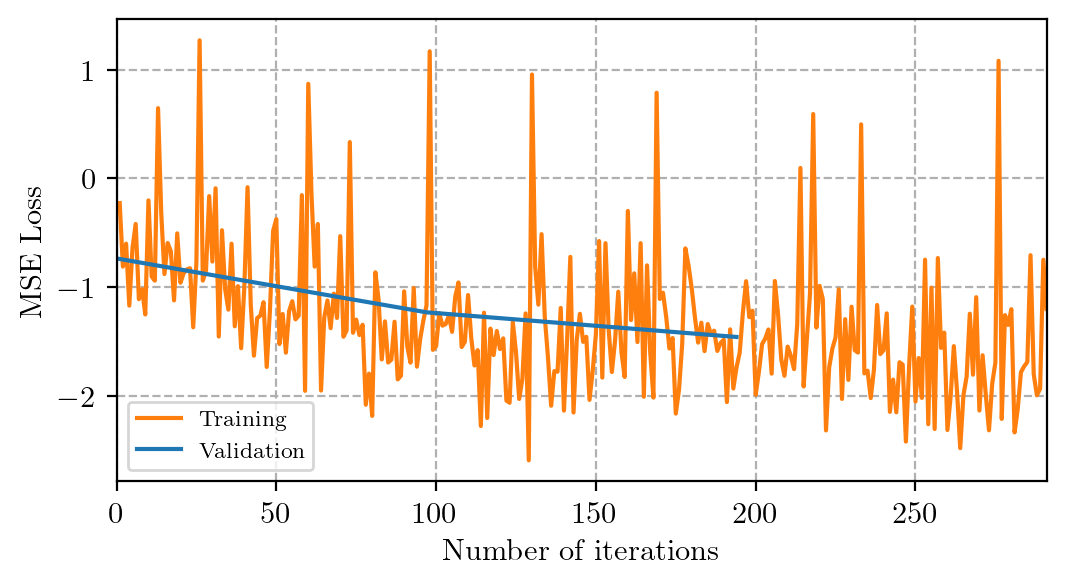

In [20]:
# Plot MSE loss throughout iterations.
model.plot_loss(filepath = None, log_scale = True)

##### Conjunction event forecasting

Forecasting next CDM from previous 21 CDM(s)...


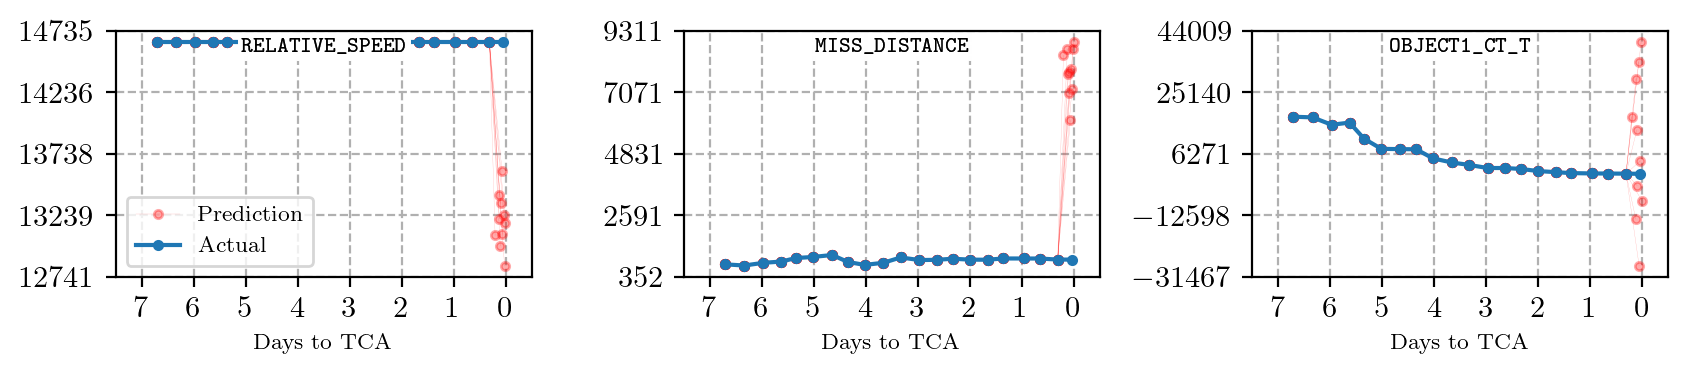

In [23]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
event_evolution = model.predict_event(event = event_beginning, 
                                      num_samples = 10, 
                                      max_length = 14)

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# Plot prediction in red
axs = event_evolution.plot_features(features = features, return_axs = True, 
                                    linewidth = 0.1, color = 'red', alpha=0.33, 
                                    label = 'Prediction')
#and the ground truth value in blue:
event.plot_features(features=features, axs=axs, label='Actual', legend = True)